# Pixel classification on OpenCL-compatible GPUs
OCLRFC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [sklearn](https://scikit-learn.org/stable/).

Let's start with loading an example image and some ground truth:

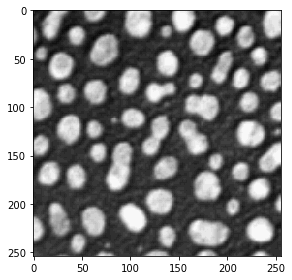

In [1]:
from skimage.io import imread, imshow
image = imread('blobs.tif')
imshow(image)

In [2]:
if False: # you can use this to make manual annotations
    import numpy as np
    import napari

    # start napari
    viewer = napari.Viewer()
    napari.run()

    # add image
    viewer.add_image(image)

    # add an empty labels layer and keep it in a variable
    labels = np.zeros(image.shape).astype(int)
    viewer.add_labels(labels)
else:
    labels = imread('annotations.tif')

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


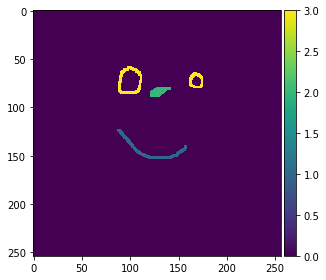

In [3]:
manual_annotations = labels

from skimage.io import imshow
imshow(manual_annotations, vmin=0, vmax=3)

## Training
We now train a OCLRandomForestClassifier, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [4]:
from apoc import PixelClassifier
import numpy as np

# define features: original image, a blurred version and an edge image
features = "original gaussian_blur=2 sobel_of_gaussian_blur=2"

# this is where the model will be saved
cl_filename = 'my_model.cl'

clf = PixelClassifier(opencl_filename=cl_filename)
clf.train(features, manual_annotations, image)

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## Prediction
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction. Prediction can be done on the CPU using the original scikit-learn code and on the GPU using the generated OpenCL-code. OCLRFC works well if both result images look identical.

In [5]:
# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
import pyclesperanto_prototype as cle
cle.set_wait_for_kernel_finish(True)
# print out which GPU is used
cle.get_device()

<gfx90c on Platform: AMD Accelerated Parallel Processing (5 refs)>

To measure prediction time without feature stack generation time, we prepare a feature stack in advance:

In [6]:
import apoc
feature_stack = apoc.generate_feature_stack(image, features)

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


gpu prediction took 0.028150558471679688 s
gpu prediction took 0.0 s
gpu prediction took 0.0 s
gpu prediction took 0.0 s
gpu prediction took 0.018474578857421875 s
gpu prediction took 0.005016803741455078 s
gpu prediction took 0.0 s
gpu prediction took 0.0 s
gpu prediction took 0.0 s
gpu prediction took 0.0 s


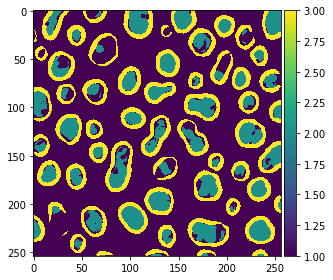

In [7]:
import time
for i in range(0, 10):
    start_time = time.time()
    result = clf.predict(feature_stack)
    print("gpu prediction took " + str(time.time() - start_time) + " s")
imshow(result)

cpu prediction took 0.04483819007873535 s
cpu prediction took 0.013023614883422852 s
cpu prediction took 0.031584978103637695 s
cpu prediction took 0.015302181243896484 s
cpu prediction took 0.031633853912353516 s
cpu prediction took 0.02067089080810547 s
cpu prediction took 0.01604628562927246 s
cpu prediction took 0.03084397315979004 s
cpu prediction took 0.03125166893005371 s
cpu prediction took 0.029611587524414062 s


C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


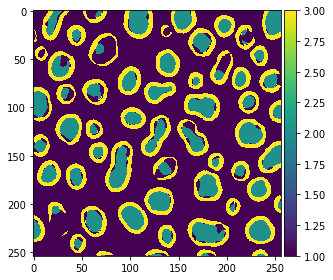

In [10]:
import time
for i in range(0, 10):
    start_time = time.time()
    result = clf._predict_cpu(feature_stack)
    print("cpu prediction took " + str(time.time() - start_time) + " s")
imshow(result)

Let's make a larger example image and run the classifier again.

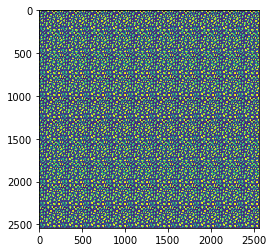

In [11]:
import pyclesperanto_prototype as cle

w = image.shape[1]
h = image.shape[0]

larger_image = cle.create([h * 10, w * 10])
for x in range(0, 10):
    for y in range(0, 10):
        cle.paste(image, larger_image, destination_x=x*w, destination_y=y*h)

cle.imshow(larger_image)

In [12]:
import apoc

start_time = time.time()
larger_feature_stack = apoc.generate_feature_stack(larger_image)
print("feature_stack generation took " + str(time.time() - start_time) + " s")

feature_stack generation took 0.060990095138549805 s


gpu prediction took 0.00780940055847168 s
gpu prediction took 0.017782926559448242 s
gpu prediction took 0.014202117919921875 s
gpu prediction took 0.009508848190307617 s
gpu prediction took 0.0 s
gpu prediction took 0.015655994415283203 s
gpu prediction took 0.0 s
gpu prediction took 0.01560211181640625 s
gpu prediction took 0.0 s
gpu prediction took 0.015657901763916016 s


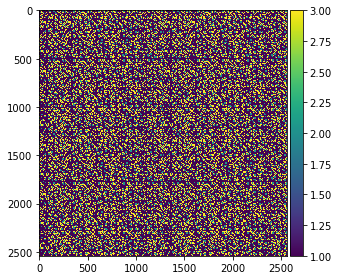

In [13]:
import time
for i in range(0, 10):
    start_time = time.time()
    result = clf.predict(larger_feature_stack)
    print("gpu prediction took " + str(time.time() - start_time) + " s")
imshow(result)

cpu prediction took 2.3662328720092773 s
cpu prediction took 2.757190227508545 s
cpu prediction took 3.019879102706909 s
cpu prediction took 2.8757617473602295 s
cpu prediction took 2.4900481700897217 s
cpu prediction took 2.525815963745117 s
cpu prediction took 2.640699863433838 s
cpu prediction took 2.786104202270508 s
cpu prediction took 2.783900499343872 s
cpu prediction took 2.844625949859619 s


C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


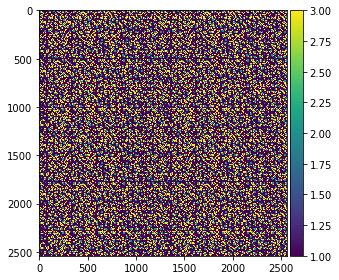

In [14]:
import time
for i in range(0, 10):
    start_time = time.time()
    result = clf._predict_cpu(larger_feature_stack)
    print("cpu prediction took " + str(time.time() - start_time) + " s")
imshow(result)

For reference, that's the OpenCL-code that generated the prediction:

In [15]:
f = open(cl_filename, "r")
print(f.read())

/*
OpenCL RandomForestClassifier
feature_specification = original gaussian_blur=2 sobel_of_gaussian_blur=2
num_classes = 3
num_features = 3
max_depth = 2
num_trees = 10
*/
__kernel void predict (IMAGE_in0_TYPE in0, IMAGE_in1_TYPE in1, IMAGE_in2_TYPE in2, IMAGE_out_TYPE out) {
 sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP_TO_EDGE | CLK_FILTER_NEAREST;
 const int x = get_global_id(0);
 const int y = get_global_id(1);
 const int z = get_global_id(2);
 float i0 = READ_IMAGE(in0, sampler, POS_in0_INSTANCE(x,y,z,0)).x;
 float i1 = READ_IMAGE(in1, sampler, POS_in1_INSTANCE(x,y,z,0)).x;
 float i2 = READ_IMAGE(in2, sampler, POS_in2_INSTANCE(x,y,z,0)).x;
 float s0=0;
 float s1=0;
 float s2=0;
if(i2<122.18116760253906){
 if(i0<180.0){
  s0+=239.0;
  s2+=32.0;
 } else {
  s1+=122.0;
  s2+=1.0;
 }
} else {
 if(i0<212.0){
  s0+=84.0;
  s1+=3.0;
  s2+=386.0;
 } else {
  s1+=7.0;
 }
}
if(i0<196.0){
 if(i2<157.81752014160156){
  s0+=267.0;
  s2+=89.0;
 } else {
  s0+=22.0;
  s2+=